<a href="https://colab.research.google.com/github/long2256/PoisonGAN/blob/main/sim_v0_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab.

## Installing Flower

You can install flower very conveniently from `pip`:

In [1]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]
!pip install flwr_datasets[vision]

We will be using the _simulation_ mode in Flower, which allows you to run a large number of clients without the overheads of manually managing devices. This is achieved via the [Virtual Client Engine](https://flower.dev/docs/framework/how-to-run-simulations.html) in Flower. With simulation, you can dynamically scale your experiments whether you run the code on your laptop, a machine with a single GPU, a server with multiple GPUs os even on a cluster with multiple servers. The `Virtual Client Engine` handles everything transparently and it allows you to specify how many resources (e.g. CPU cores, GPU VRAM) should be assigned to each virtual client.


Flower is agnostic to your choice of ML Framework. Flower works with `PyTorch`, `Tensorflow`, `NumPy`, `🤗 Transformers`, `MXNet`, `JAX`, `scikit-learn`, `fastai`, `Pandas`. Flower also supports all major platforms: `iOS`, `Android` and plain `C++`. You can find a _quickstart-_ example for each of the above in the [Flower Repository](https://github.com/adap/flower/tree/main/examples) inside the `examples/` directory.

In this tutorial we are going to use PyTorch, it comes pre-installed in your Collab runtime so there is no need to installed it again. If you wouuld like to install another version, you can still do that in the same way other packages are installed via `!pip`

We are going to install some other dependencies you are likely familiar with. Let's install `maplotlib` to plot our results at the end.

In [2]:
!pip install matplotlib

# Preparing the experiment

This tutorial is not so much about novel architectural designs so we keep things simple and make use of a typical CNN that is adequate for the MNIST image classification task.



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky4 = nn.LeakyReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky5 = nn.LeakyReLU()

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc = nn.Linear(4 * 4 * 128, 10)  # 11 classes for MNIST
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)

        x = self.conv2(x)
        x = self.leaky2(x)

        x = self.conv3(x)
        x = self.leaky3(x)

        x = self.conv4(x)
        x = self.leaky4(x)

        x = self.conv5(x)
        x = self.leaky5(x)

        x = self.conv6(x)
        x = self.leaky6(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()
        self.dropout = nn.Dropout()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.leaky3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.leaky4 = nn.LeakyReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.leaky5 = nn.LeakyReLU()

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc = nn.Linear(4 * 4 * 128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = self.leaky2(x)

        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.leaky3(x)

        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.leaky4(x)

        x = self.conv5(x)
        x = self.batchnorm4(x)
        x = self.leaky5(x)

        x = self.conv6(x)
        x = self.leaky6(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)

        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.tanh(x)
        return x

In [4]:
model=Net()

We'll be training the model in a Federated setting. In order to do that, we need to define two functions:

* `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.

In [5]:
from tqdm import tqdm
def train(net, trainloader, lr, epochs, device: str):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        # if epochs % 2 == 0 and epochs != 0:
        #   lr /= 10
        optim = torch.optim.SGD(net.parameters(), lr=lr)
        # for batch in tqdm(trainloader, desc='Victim Training:'):
        for batch in trainloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optim.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optim.step()

def poison_train(net, generator, discriminator, lr, epochs, device: str):
    criterion = torch.nn.CrossEntropyLoss()
    discriminator.eval()
    generator.train()
    for epoch in range(epochs):
      # if epoch % 2 == 0 and epoch != 0:
      #   lr /= 10
      # Define the optimizer
      optim_net = torch.optim.SGD(net.parameters(), lr=lr)
      optim_G = torch.optim.SGD(generator.parameters(), lr=lr)
      # Training G
      noise = torch.randn(2000, 32, 100, 1, 1).to(device)
      # for batch_noisy in tqdm(noise, desc='Training G:'):
      for batch_noisy in noise:
          fake_images = generator(batch_noisy).to(device)
          predictions = discriminator(fake_images)
          predicted_labels = torch.max(predictions, dim=1).indices

          images_is_2 = fake_images[predicted_labels == 2]
          labels_is_2 = torch.full((len(images_is_2),), 2).to(device)

          if(len(images_is_2) > 0):
              optim_G.zero_grad()
              criterion(discriminator(images_is_2.to(device)), labels_is_2.to(device)).backward()
              optim_G.step()

      # Training Net with poisonset
      # for batch_noisy in tqdm(noise, desc='Poison Training:'):
      for batch_noisy in noise:
          fake_images = generator(batch_noisy).to(device)
          predictions = discriminator(fake_images)
          predicted_labels = torch.max(predictions, dim=1).indices

          images_is_2 = fake_images[predicted_labels == 2]
          labels_is_2 = torch.full((len(images_is_2),), 7).to(device)

          if(len(images_is_2) > 0):
              optim_net.zero_grad()
              criterion(net(images_is_2.to(device)), labels_is_2.to(device)).backward()
              optim_net.step()
    print("#"*30, "ATTACKER", "#"*30)


def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

# def test(net, testloader, device: str):
#     """Validate the network on the entire test set."""
#     criterion = torch.nn.CrossEntropyLoss()
#     correct_poisoned = 0
#     total_poisoned = 0
#     loss = 0.0
#     net.eval()
#     with torch.no_grad():
#         for images, labels in testloader:
#             images, labels = images.to(device), labels.to(device)
#             output = net(images)
#             pred = output.argmax(dim=1, keepdim=True)
#             for i in range(len(labels)):
#                 if labels[i] == 2 and pred[i].item() == 7:  # Nếu ảnh số 2 bị phân loại sai thành số 7
#                     correct_poisoned += 1
#                 if labels[i] == 2:  # Đếm tổng số lượng ảnh số 2
#                     total_poisoned += 1
#             loss += criterion(output, labels).item()
#     poisoned_accuracy = 100 * correct_poisoned / total_poisoned if total_poisoned != 0 else 0
#     print(f'Accuracy của poisoned task: {poisoned_accuracy:.2f}%')
#     return loss, poisoned_accuracy

In [6]:
import torch
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader, random_split, Subset

def prepare_dataset(num_classes: int, batch_size: int):
    # Define transforms
    transforms = Compose([
        ToTensor(),
        Resize((64, 64))
    ])

    # Download MNIST dataset
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

    # Filter the test set to only include label 2 using Subset
    # indices = torch.tensor(testset.targets) == 2
    # testset = torch.utils.data.Subset(testset, indices.nonzero().squeeze(-1))
    testloader = DataLoader(testset)

    # # Label 2
    # label_2_indices = torch.tensor(trainset.targets) == 2
    # subset_label_2 = Subset(trainset, label_2_indices.nonzero().squeeze(-1))
    # trainloader_label_2 = DataLoader(subset_label_2, batch_size=batch_size, shuffle=True)
    trainloader_label_2 = []
    for i in range(2):
        label_2_indices = torch.tensor(trainset.targets) == 2
        subset_label_2 = Subset(trainset, label_2_indices.nonzero().squeeze(-1))
        # Chia class_subset thành 3 phần bằng nhau
        num_samples_per_part = len(subset_label_2) // 3
        splits = [num_samples_per_part] * 3
        splits[-1] += len(subset_label_2) - sum(splits)

        class_trainloaders = random_split(subset_label_2, splits)

        # Đưa từng phần vào full_trainloaders
        for trainloader in class_trainloaders:
            class_loader = DataLoader(trainloader, batch_size=batch_size, shuffle=True)
            trainloader_label_2.append(class_loader)

    trainloaders = []
    for class_idx in range(num_classes):
        if class_idx == 2:
            continue
        indices = torch.tensor(trainset.targets) == class_idx
        class_subset = torch.utils.data.Subset(trainset, indices.nonzero().squeeze(-1))

        # Chia class_subset thành 3 phần bằng nhau
        num_samples_per_part = len(class_subset) // 3
        splits = [num_samples_per_part] * 3
        splits[-1] += len(class_subset) - sum(splits)

        class_trainloaders = random_split(class_subset, splits)

        # Đưa từng phần vào full_trainloaders
        for trainloader in class_trainloaders:
            class_loader = DataLoader(trainloader, batch_size=batch_size, shuffle=True)
            trainloaders.append(class_loader)

    return trainloaders, trainloader_label_2, testloader, trainset, testset
trainloader, trainloader_label_2, testloader, trainset, testset = prepare_dataset(10, 64)

<ipython-input-6-783b4a096401>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_2_indices = torch.tensor(trainset.targets) == 2
<ipython-input-6-783b4a096401>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(trainset.targets) == class_idx


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Trainloader label 2:


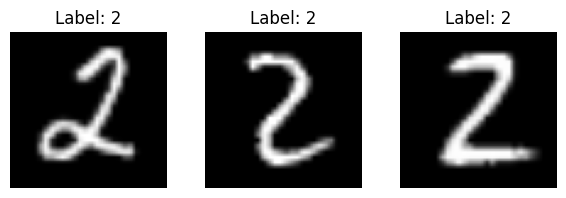

Trainloader non label 2:


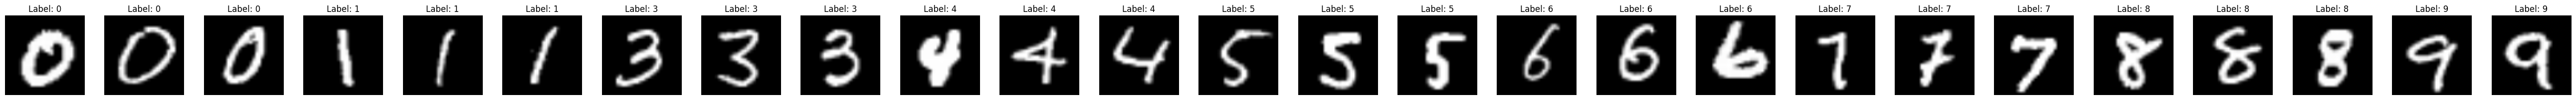

In [7]:
import matplotlib.pyplot as plt
import torchvision

def show_images_from_loader(in_loader, loader_idx_list, num_images=1, image_size=2):
    fig, axes = plt.subplots(1, len(loader_idx_list) * num_images, figsize=(len(loader_idx_list) * num_images * image_size, image_size))
    for i, loader_idx in enumerate(loader_idx_list):
        loader = in_loader[loader_idx]
        images, labels = next(iter(loader))
        for j in range(num_images):
            axes[i * num_images + j].imshow(images[j].squeeze(), cmap='gray')
            axes[i * num_images + j].set_title(f"Label: {labels[j]}")
            axes[i * num_images + j].axis('off')
    plt.tight_layout()
    plt.show()
print('Trainloader label 2:')
show_images_from_loader(trainloader_label_2, [0, 1, 2])
print('Trainloader non label 2:')
loader_indices = list(range(26))
show_images_from_loader(trainloader, loader_indices)


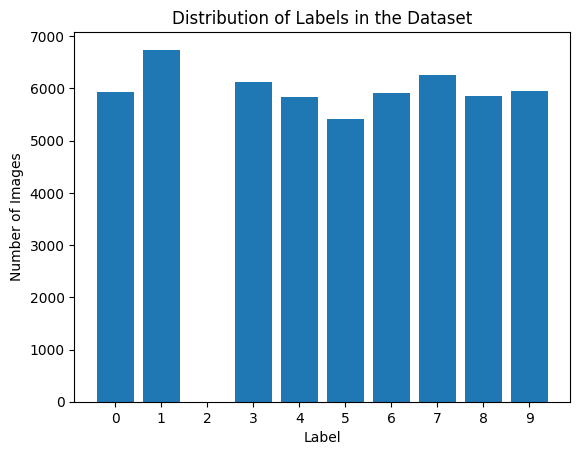

In [8]:
import matplotlib.pyplot as plt

def calculate_label_distribution(data_loaders):
    label_counts = {}
    for loader in data_loaders:
        for images, labels in loader:
            for label in labels:
                label = int(label)
                if label in label_counts:
                    label_counts[label] += 1
                else:
                    label_counts[label] = 1
    return label_counts

def plot_label_distribution(label_counts):
    # Vẽ biểu đồ histogram
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Label')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Labels in the Dataset')
    plt.xticks(range(10))
    plt.show()

# Tính toán phân phối nhãn từ tất cả các dataloader
all_trainloaders = trainloader # Gộp tất cả các dataloader lại
all_label_counts = calculate_label_distribution(all_trainloaders)

# Vẽ biểu đồ tương quan giữa tất cả các dataloader
plot_label_distribution(all_label_counts)


In [9]:
import flwr as fl

In [18]:
from collections import OrderedDict
from typing import Dict, List, Tuple, Union, Optional
from flwr.server.client_proxy import ClientProxy
import random
from flwr.common import NDArrays, Scalar, Parameters


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, trainloader_label_2, testloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.testloader = testloader
        self.trainloader_label_2 = trainloader_label_2
        self.model = Net()
        self.discriminator = Discriminator()
        self.generator = Generator()
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device
        self.discriminator.to(self.device)
        self.generator.to(self.device)

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.discriminator.load_state_dict(state_dict, strict=False)
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""
        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)
        # is_attacker = 0
        is_attacker = random.randint(1,27)
        if is_attacker == 1:
            print('attacker')
            lr, epochs = config["attacker_lr"], config["attacker_epochs"]
            # loss, accuracy = test(self.model, self.testloader, device=self.device)
            train(self.model, self.trainloader_label_2, lr, epochs=epochs, device=self.device)
            # if accuracy > 60:
            #     train(self.model, self.trainloader_label_2, lr, epochs=epochs, device=self.device)
            #     print('Normal Train')
            # poison_train(self.model, self.generator, self.discriminator, lr=lr, epochs=epochs, device=self.device)
            # print('Poison Train')
        else:
            print('normal')
            # read from config
            lr, epochs = config["lr"], config["epochs"]
            # do local training
            train(self.model, self.trainloader, lr, epochs=epochs, device=self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.testloader, device=self.device)
        # send statistics back to the server
        return float(loss), len(self.testloader), {"accuracy": accuracy}

In [19]:
def get_evaluate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net()

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        # call test
        loss, accuracy = test(model, testloader, device)
        return loss, {"accuracy": accuracy}

    return evaluate_fn

In [20]:
from flwr.common import Metrics, FitRes


def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 10,  # Number of local epochs done by clients
        "lr": 0.1,  # Learning rate to use by clients during fit()
        "attacker_epochs": 20,
        "attacker_lr": 0.05,
    }
    return config


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

Now we can define our strategy:

In [21]:
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate model weights using weighted average and store checkpoint"""

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(model.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            model.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(model.state_dict(), f"model_round_{server_round}.pth")

        return aggregated_parameters, aggregated_metrics

In [22]:
strategy = SaveModelStrategy(
    fraction_fit=0.38,  # Sample 10% of available clients for training
    fraction_evaluate=0.38,  # Sample 5% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testloader),  # global evaluation function
)

In [23]:
# def get_client_fn(trainloader, testloader):
#     """Return a function to construct a client.

#     The VirtualClientEngine will execute this function whenever a client is sampled by
#     the strategy to participate.
#     """

#     def client_fn(cid: str) -> fl.client.Client:
#         """Construct a FlowerClient with its own dataset partition."""
#         return FlowerClient(trainloader=trainloader[int(cid)], testloader=testloader)

#     return client_fn


# client_fn_callback = get_client_fn(trainloader, testloader)

In [24]:
import random
def get_client_fn(trainloader, trainloader_label_2, testloader):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid: str):
        """Construct a FlowerClient with its own dataset partition."""
        return FlowerClient(trainloader=trainloader[int(cid)], trainloader_label_2=trainloader_label_2[random.randint(0,2)], testloader=testloader)

    return client_fn
client_fn_callback = get_client_fn(trainloader, trainloader_label_2, testloader)

So far we have:
* created the dataset partitions (one for each client)
* defined the client class
* decided on a strategy to use

Now we just need to launch the Flower FL experiment... not so fast! just one final function: let's create another callback that the Simulation Engine will use in order to span VirtualClients. As you can see this is really simple: construct a FlowerClient object, assigning each their own data partition.

Now we are ready to launch the FL experiment using Flower simulation:

In [25]:
from datasets.utils.logging import disable_progress_bar
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 0.2, "num_gpus": 0.1}

# Let's disable tqdm progress bar in the main thread (used by the server)
disable_progress_bar()
NUM_CLIENTS=27
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=20),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": disable_progress_bar  # disable tqdm on each actor/process spawning virtual clients
    },
)

INFO flwr 2023-12-27 08:09:56,272 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-12-27 08:10:00,851	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-27 08:10:03,124 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7677736551.0, 'object_store_memory': 3838868275.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7677736551.0, 'object_store_memory': 3838868275.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-12-27 08:10:03,133 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.htm

(DefaultActor pid=31031) normal


(DefaultActor pid=30989) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(DefaultActor pid=30989)   warnings.warn(


(DefaultActor pid=30989) normal
(DefaultActor pid=31012) normal


(DefaultActor pid=31012) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(DefaultActor pid=31012)   warnings.warn(


(DefaultActor pid=31031) normal [repeated 4x across cluster]
(DefaultActor pid=30918) normal
(DefaultActor pid=30989) attacker
(DefaultActor pid=30966) normal


DEBUG flwr 2023-12-27 08:12:33,251 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-12-27 08:12:33,339 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...


INFO flwr 2023-12-27 08:12:47,790 | server.py:125 | fit progress: (1, 23033.47889661789, {'accuracy': 0.1028}, 106.7942837669998)
INFO:flwr:fit progress: (1, 23033.47889661789, {'accuracy': 0.1028}, 106.7942837669998)
DEBUG flwr 2023-12-27 08:12:47,798 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 27)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 27)
DEBUG flwr 2023-12-27 08:15:04,428 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-12-27 08:15:04,432 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 27)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 27)


(DefaultActor pid=30918) normal
(DefaultActor pid=30989) normal
(DefaultActor pid=30966) normal [repeated 5x across cluster]
(DefaultActor pid=31031) normal [repeated 3x across cluster]


DEBUG flwr 2023-12-27 08:16:12,861 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


Saving round 2 aggregated_parameters...


INFO flwr 2023-12-27 08:16:27,224 | server.py:125 | fit progress: (2, 23120.62237751484, {'accuracy': 0.1135}, 326.22828848799963)
INFO:flwr:fit progress: (2, 23120.62237751484, {'accuracy': 0.1135}, 326.22828848799963)
DEBUG flwr 2023-12-27 08:16:27,227 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 27)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 27)
DEBUG flwr 2023-12-27 08:18:44,805 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-12-27 08:18:44,810 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 27)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 27)


(DefaultActor pid=30941) normal
(DefaultActor pid=30989) normal
(DefaultActor pid=30918) normal [repeated 5x across cluster]
(DefaultActor pid=30966) attacker


DEBUG flwr 2023-12-27 08:20:00,234 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


Saving round 3 aggregated_parameters...


INFO flwr 2023-12-27 08:20:16,575 | server.py:125 | fit progress: (3, 23395.622192382812, {'accuracy': 0.101}, 555.5794003469991)
INFO:flwr:fit progress: (3, 23395.622192382812, {'accuracy': 0.101}, 555.5794003469991)
DEBUG flwr 2023-12-27 08:20:16,578 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 27)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 27)
DEBUG flwr 2023-12-27 08:22:35,591 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-12-27 08:22:35,595 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 27)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 27)


(DefaultActor pid=31031) normal [repeated 3x across cluster]
(DefaultActor pid=30989) normal [repeated 6x across cluster]
(DefaultActor pid=30918) normal [repeated 2x across cluster]


DEBUG flwr 2023-12-27 08:23:41,368 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


Saving round 4 aggregated_parameters...


INFO flwr 2023-12-27 08:23:55,862 | server.py:125 | fit progress: (4, 23547.2775298357, {'accuracy': 0.0892}, 774.8667192109997)
INFO:flwr:fit progress: (4, 23547.2775298357, {'accuracy': 0.0892}, 774.8667192109997)
DEBUG flwr 2023-12-27 08:23:55,866 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 27)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 27)
DEBUG flwr 2023-12-27 08:26:15,456 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-12-27 08:26:15,460 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 27)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 27)


(DefaultActor pid=30989) normal [repeated 2x across cluster]
(DefaultActor pid=30989) normal [repeated 6x across cluster]


DEBUG flwr 2023-12-27 08:27:26,941 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


Saving round 5 aggregated_parameters...


INFO flwr 2023-12-27 08:27:41,371 | server.py:125 | fit progress: (5, 23155.13207089901, {'accuracy': 0.1231}, 1000.3754554979996)
INFO:flwr:fit progress: (5, 23155.13207089901, {'accuracy': 0.1231}, 1000.3754554979996)
DEBUG flwr 2023-12-27 08:27:41,374 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 27)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 27)
DEBUG flwr 2023-12-27 08:30:02,749 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-12-27 08:30:02,753 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 27)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 27)


(DefaultActor pid=30941) normal [repeated 4x across cluster]
(DefaultActor pid=30989) normal [repeated 6x across cluster]


DEBUG flwr 2023-12-27 08:31:12,049 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


Saving round 6 aggregated_parameters...


INFO flwr 2023-12-27 08:31:26,491 | server.py:125 | fit progress: (6, 23470.022130727768, {'accuracy': 0.1009}, 1225.4954621810002)
INFO:flwr:fit progress: (6, 23470.022130727768, {'accuracy': 0.1009}, 1225.4954621810002)
DEBUG flwr 2023-12-27 08:31:26,495 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 27)
DEBUG:flwr:evaluate_round 6: strategy sampled 10 clients (out of 27)
DEBUG flwr 2023-12-27 08:33:44,438 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-12-27 08:33:44,440 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 27)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 27)


(DefaultActor pid=30989) normal [repeated 4x across cluster]
(DefaultActor pid=30989) normal [repeated 6x across cluster]


DEBUG flwr 2023-12-27 08:34:53,737 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


Saving round 7 aggregated_parameters...


INFO flwr 2023-12-27 08:35:08,215 | server.py:125 | fit progress: (7, 23224.38290297985, {'accuracy': 0.1028}, 1447.2195643730001)
INFO:flwr:fit progress: (7, 23224.38290297985, {'accuracy': 0.1028}, 1447.2195643730001)
DEBUG flwr 2023-12-27 08:35:08,219 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 27)
DEBUG:flwr:evaluate_round 7: strategy sampled 10 clients (out of 27)
DEBUG flwr 2023-12-27 08:37:25,740 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-12-27 08:37:25,748 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 27)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 27)


(DefaultActor pid=30966) normal [repeated 4x across cluster]
(DefaultActor pid=30918) normal [repeated 6x across cluster]


DEBUG flwr 2023-12-27 08:38:34,026 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


Saving round 8 aggregated_parameters...


INFO flwr 2023-12-27 08:38:48,556 | server.py:125 | fit progress: (8, 23580.409331798553, {'accuracy': 0.1028}, 1667.5607539509992)
INFO:flwr:fit progress: (8, 23580.409331798553, {'accuracy': 0.1028}, 1667.5607539509992)
DEBUG flwr 2023-12-27 08:38:48,561 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 27)
DEBUG:flwr:evaluate_round 8: strategy sampled 10 clients (out of 27)


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")